In [1]:
import time
import picamera
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
#%config InlineBackend.figure_format = "svg"
import sys
sys.path.append("..")
import SHSlib  as sh
import cv2 as cv
%load_ext autoreload
%autoreload 2

# Raw Camera Signal

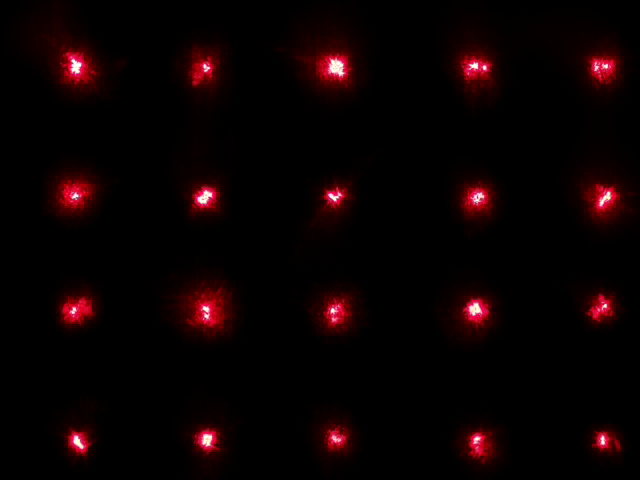

KeyboardInterrupt: 

In [2]:



with picamera.PiCamera(
        sensor_mode= 4,  # 1640x1232, full FoV, binning 2x2
        resolution= (640,480),
        #resolution= (2028,1524),
        framerate= 90
) as camera:
    time.sleep(1)  # let the camera warm up and set gain/white balance
    camera.exposure_mode = 'off'
    camera.awb_mode = 'off'
    camera.awb_gains = 2
    camera.shutter_speed = int(6e5)
    camera.iso = 1
    output = np.zeros((480,640,3), dtype=np.uint8)
    t1 = time.time_ns()
    for i in range(100000): 
        camera.capture(output,'rgb',use_video_port=True)
        img = output.astype(np.uint16)
        for j in range(10):
            camera.capture(output,'rgb',use_video_port=True)
            img += Image.fromarray(output,'RGB')
        
        img = (img/11).astype(np.uint8)
        img = Image.fromarray(img,'RGB')
        
        
        t2 = time.time_ns()
        display(img,clear=True)    
    #t2 = time.time_ns()
    #print(50/((t2 - t1)/1e9))

# Live-Plot: Point Shift 

In [3]:
10 < 40

True

<IPython.core.display.Javascript object>


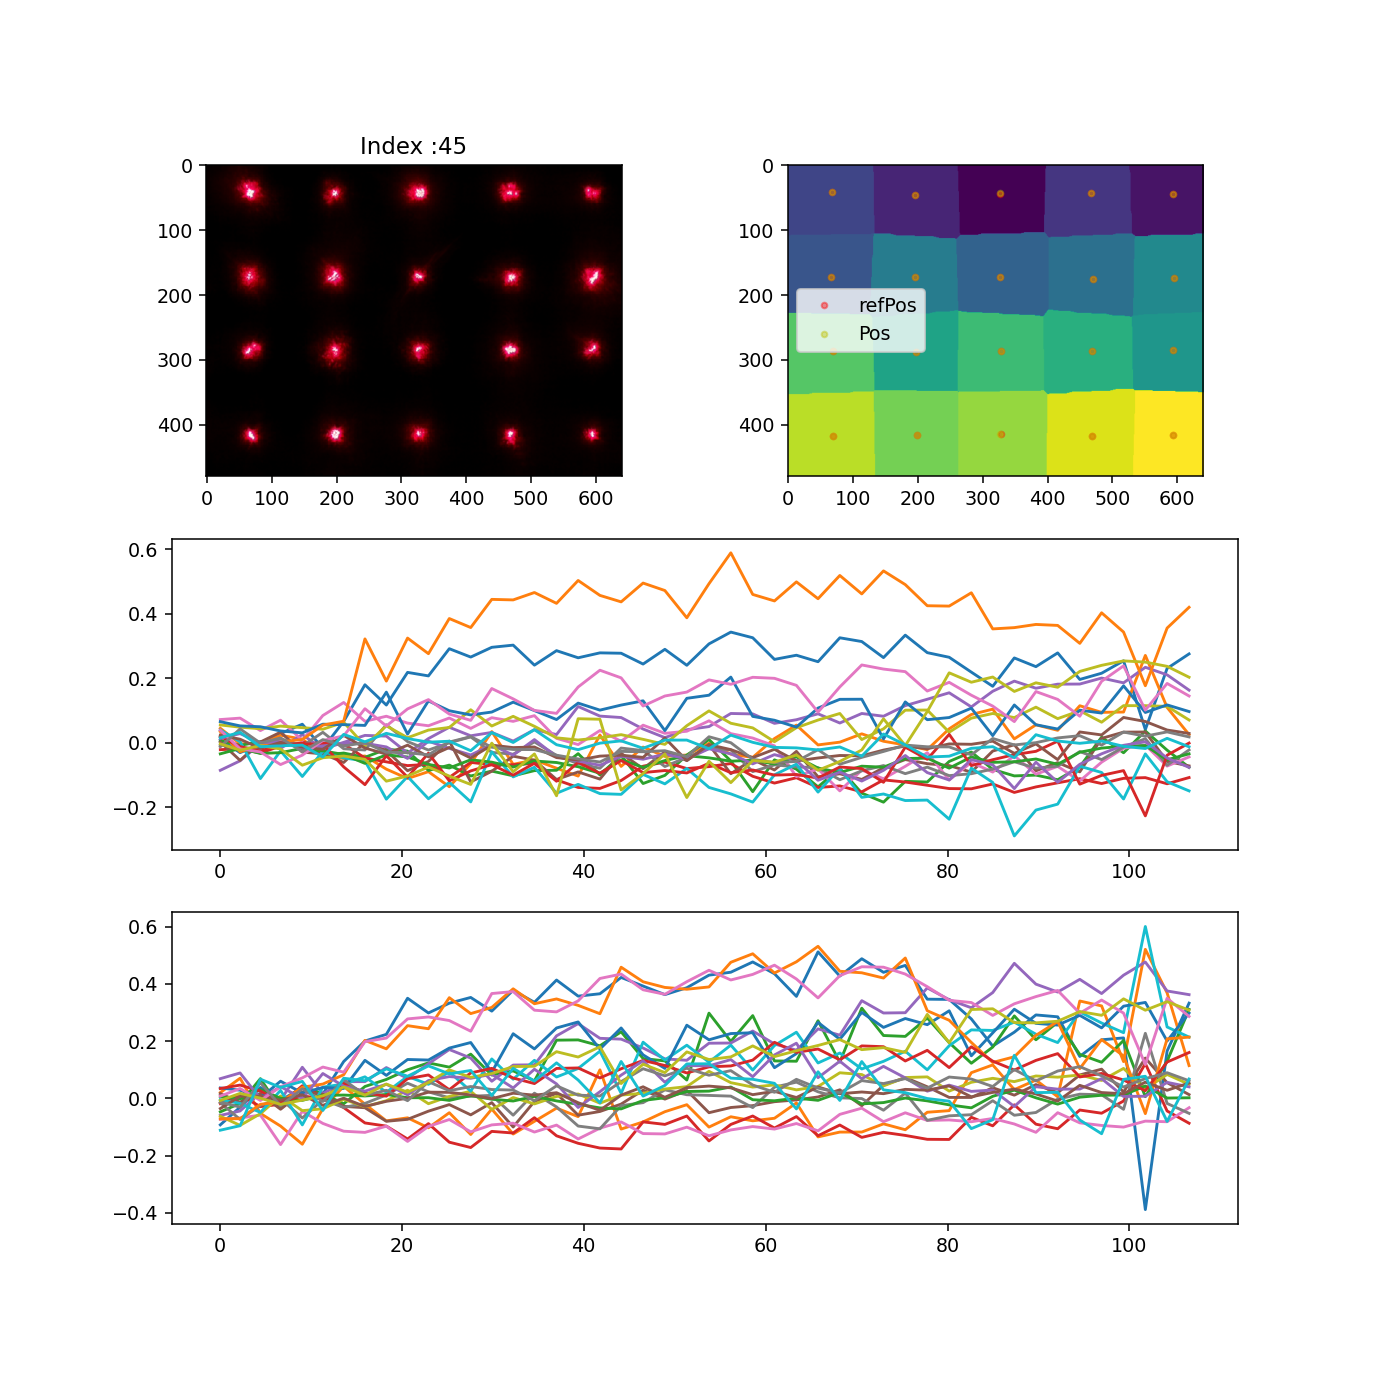

KeyboardInterrupt: 

In [4]:

indx = 0 
resolution = (640,480)
#resolution = (1280,720)
#resolution = (1640,1232)
#resolution =(2016, 1520)

min_distance = 40

indx_end = 1000




try:
    with picamera.PiCamera(
        # Camera Setup 
        sensor_mode= 4,  
        resolution= resolution,
        framerate= 30
    ) as camera:
        # addition camera setup
        time.sleep(1)  # let the camera warm up and set gain/white balance
        camera.exposure_mode = 'off'
        camera.awb_mode = 'off'
        camera.awb_gains = 2.5

        camera.shutter_speed = int(6e6)
        camera.iso = 50
        output = np.zeros((*reversed(resolution),3), dtype=np.uint8)

        # get ref image
        for i in range(5):
            camera.capture(output,'rgb',use_video_port=True)

        PIL_ref_img = Image.fromarray(output,'RGB')
        ref_img = np.mean(PIL_ref_img,2) 
        ref_img[ref_img < 40] = 0
        # precess pef image
        ref_lables = sh.analyse.getSeperation(ref_img,min_distance=min_distance)
        ref_center = sh.analyse.getMomentum(ref_lables,ref_img, algorythm="C") 
        ShiftOverTimeX = np.zeros((len(ref_center[0]),indx_end))
        ShiftOverTimeY = np.zeros((len(ref_center[0]),indx_end))

        timeOfCapture = np.zeros(indx_end)
        timeOfCapture[0] = 0


        fig = plt.figure(figsize=(10,10))
        axSensor = fig.add_subplot(321)
        axPeakArea = fig.add_subplot(322)
        axPeakPosOverTime = fig.add_subplot(312)
        axPeakPosOverTime2 = fig.add_subplot(313)
        #axPeakPosOverTime2 = fig.add_subplot(211)

        imageSensorImg =  axSensor.imshow(PIL_ref_img)

        imagePeakArea = axPeakArea.imshow(ref_lables)
        linePeakPoints1 = axPeakArea.plot(ref_center[0],ref_center[1],"r.",label='refPos',linewidth=0.1,alpha=0.4)
        linePeakPoints2 = axPeakArea.plot(ref_center[0],ref_center[1],"y.",label='Pos',linewidth=0.1,alpha=0.4)
        axPeakArea.legend()

        linePeakPosOverXTime = []
        linePeakPosOverYTime = []
        for i in range(len(ref_center[0])):
            linePeakPosOverXTime += [axPeakPosOverTime.plot(ref_center[0][i])]
            linePeakPosOverYTime += [axPeakPosOverTime2.plot(ref_center[1][i])]
        fig.canvas.draw()
        plt.show()

        t0 = time.time_ns()

        for i in range(0,indx_end):
            t1 = time.time_ns()
            # continuous capture 
            camera.capture(output,'rgb',use_video_port=True) # 50ms
            timeOfCapture[i] = (time.time_ns() - t0) /1e9

            Sensor_img = Image.fromarray(output,'RGB') #5ms

            img = np.int16(output)
            img = np.uint8((img[:,:,0] + img[:,:,1] + img[:,:,2])/3)
            img[img < 40] = 0
            #%time img = np.mean(Sensor_img,2)

            center = sh.analyse.getMomentum(ref_lables, img, algorythm="C") 
            partners = sh.analyse.getPartner(center, ref_center)


            ShiftOverTimeX[:,i] = partners[0]
            ShiftOverTimeY[:,i] = partners[1]

            #print((time.time_ns() - t1)/1e6)
            if True: #i%0 == 0:
                # Set data for Ploting
                imageSensorImg.set_data(Sensor_img) 

                #imagePeakArea.set_data(img)

                linePeakPoints2[0].set_xdata(center[0])
                linePeakPoints2[0].set_ydata(center[1])
                axSensor.set_title("Index :" + str(indx))


                for j in range(len(ShiftOverTimeX[:,i])):
                    linePeakPosOverYTime[j][0].set_ydata(ShiftOverTimeX[j,0:i+1])
                    linePeakPosOverYTime[j][0].set_xdata(timeOfCapture[0:i+1])

                    linePeakPosOverXTime[j][0].set_ydata(ShiftOverTimeY[j,0:i+1])
                    linePeakPosOverXTime[j][0].set_xdata(timeOfCapture[0:i+1])

                    axPeakPosOverTime.relim() 
                    axPeakPosOverTime.autoscale_view(True,True,True) 

                    axPeakPosOverTime2.autoscale_view(True,True,True) 
                    axPeakPosOverTime2.relim() 
                fig.canvas.draw()
            indx += 1 
except Exception:
    print("")

<IPython.core.display.Javascript object>


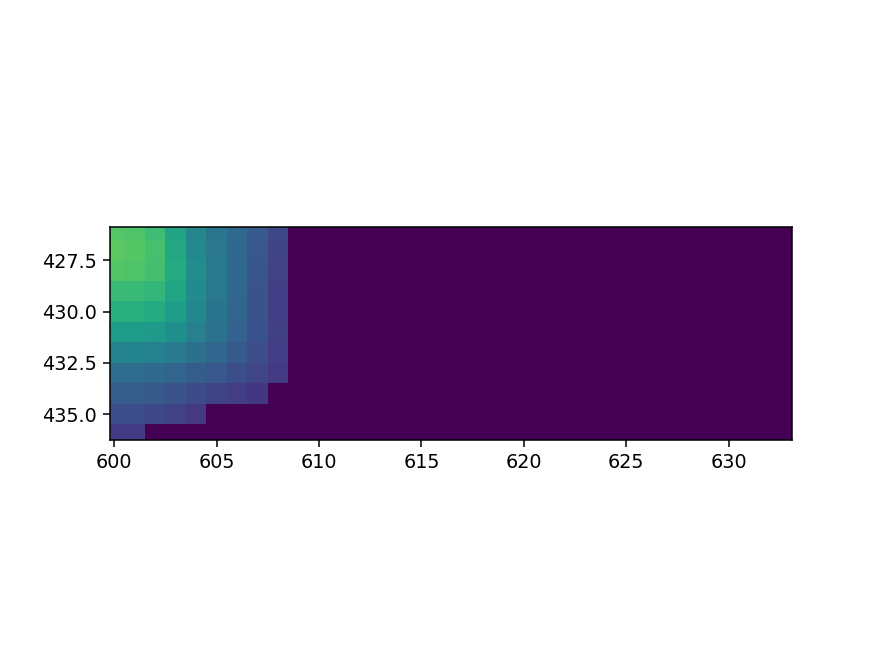

In [11]:
plt.imshow(ref_img)

<IPython.core.display.Javascript object>


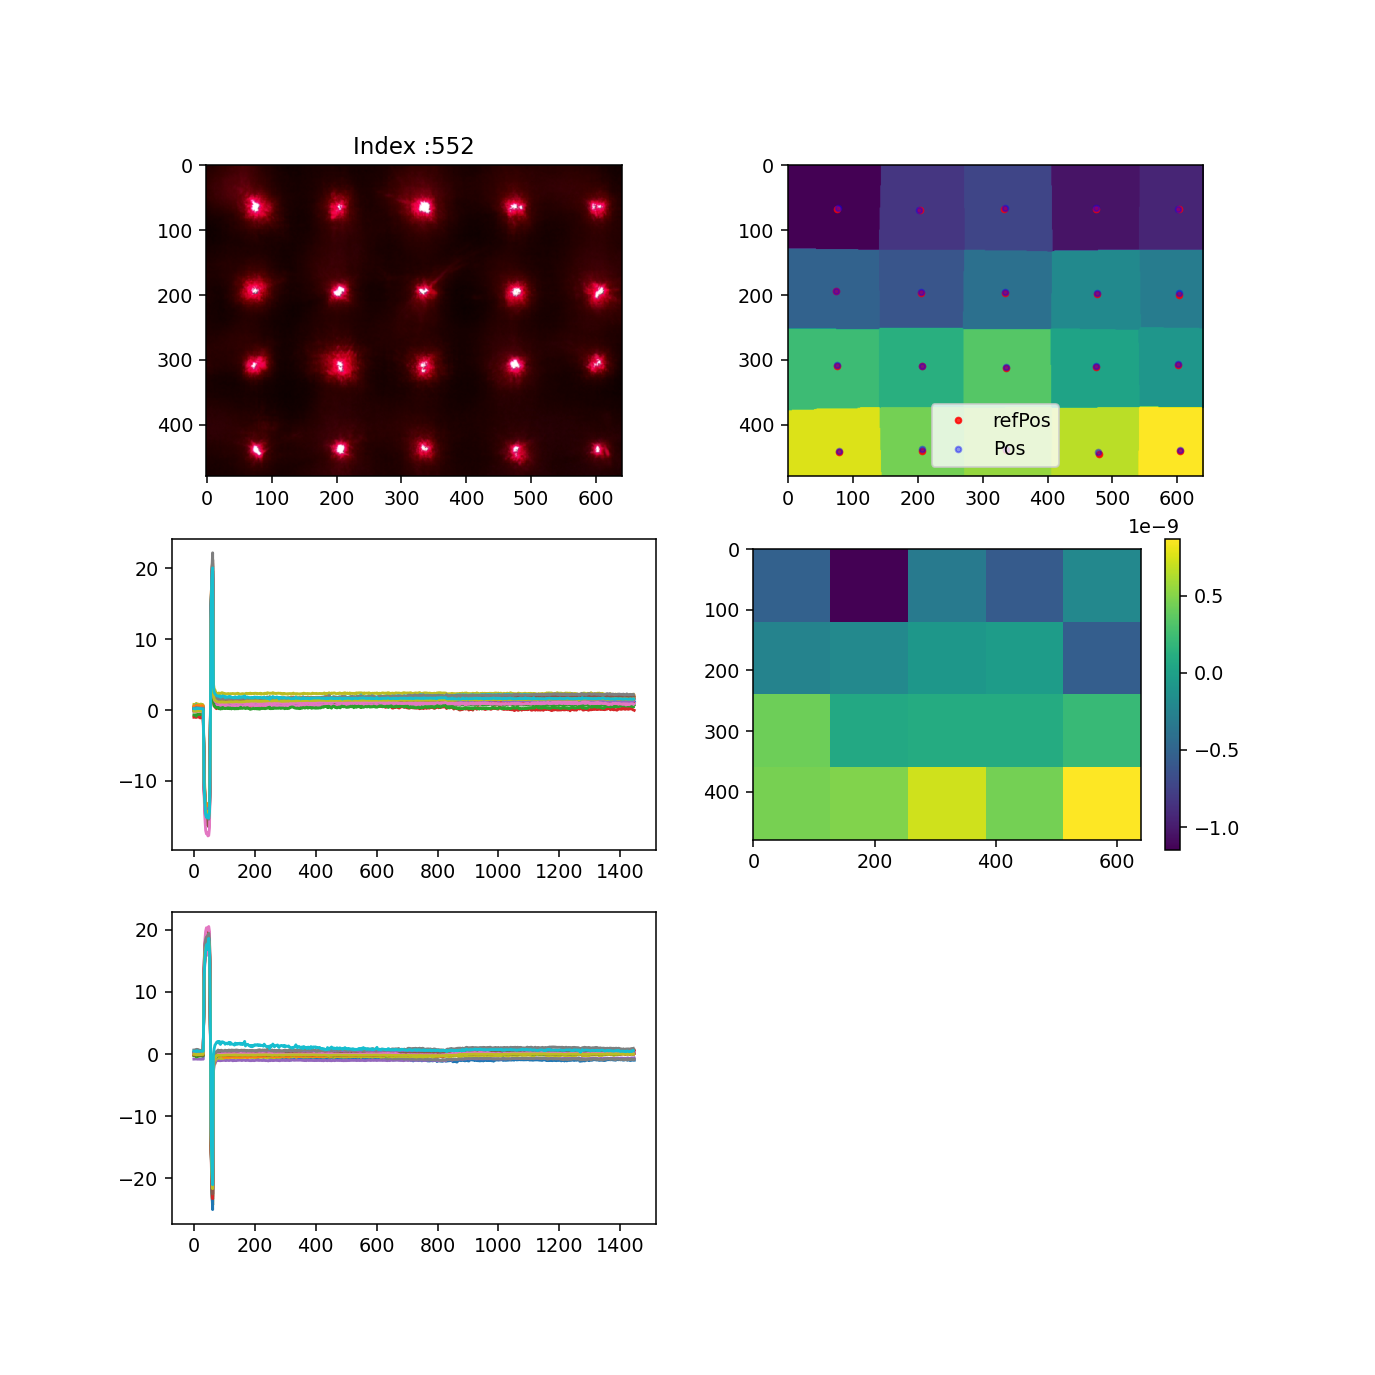

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/pi/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_876/3315511489.py", line 137, in <module>
    axPeakPosOverTime2.relim()
  File "/home/pi/.local/lib/python3.7/site-packages/matplotlib/axes/_base.py", line 2451, in relim
    self._update_line_limits(artist)
  File "/home/pi/.local/lib/python3.7/site-packages/matplotlib/axes/_base.py", line 2337, in _update_line_limits
    updatex, updatey = line_trf.contains_branch_seperately(self.transData)
  File "/home/pi/.local/lib/python3.7/site-packages/matplotlib/transforms.py", line 1424, in contains_branch_seperately
    return [self.contains_branch(other_transform)] * 2
  File "/home/pi/.local/lib/python3.7/site-packages/matplotlib/transforms.py", line 1404, in contains_branch
    if sub_tree == other:
  File "/home/pi/.local/lib/python3.7/site-packages/matplotlib/transfor

TypeError: object of type 'NoneType' has no len()

In [3]:

indx = 0 
resolution = (640,480)
#resolution = (1280,720)
#resolution = (1640,1232)
#resolution =(2016, 1520)

min_distance = 30

indx_end = 1000




#try:
with picamera.PiCamera(
    # Camera Setup 
    sensor_mode= 4,  
    resolution= resolution,
    framerate= 30
) as camera:
    # addition camera setup
    time.sleep(1)  # let the camera warm up and set gain/white balance
    camera.exposure_mode = 'off'
    camera.awb_mode = 'off'
    camera.awb_gains = 2.5

    camera.shutter_speed = int(6e6)
    camera.iso = 50
    output = np.zeros((*reversed(resolution),3), dtype=np.uint8)

    # -- get ref image
    for i in range(5):
        camera.capture(output,'rgb',use_video_port=True)
    
    PIL_ref_img = Image.fromarray(output,'RGB')
    ref_img = np.mean(PIL_ref_img,2) 
    ref_img = cv.blur(ref_img,(5,5))
    ref_img[ref_img < 40] = 0
    # -- precess pef image
    ref_lables = sh.analyse.getSeperation(ref_img,min_distance=min_distance)
    ref_center = sh.analyse.getMomentum(ref_lables,ref_img, algorythm="C") 
    ShiftOverTimeX = np.zeros((len(ref_center[0]),indx_end))
    ShiftOverTimeY = np.zeros((len(ref_center[0]),indx_end))

    timeOfCapture = np.zeros(indx_end)
    timeOfCapture[0] = 0

    # -- create Plot
    fig = plt.figure(figsize=(10,10))
    axSensor = fig.add_subplot(321)
    axPeakArea = fig.add_subplot(322)
    axIntegraion = fig.add_subplot(324)
    imageIntegraion = axIntegraion.imshow(PIL_ref_img)
    imageIntegraionColourbar = plt.colorbar(imageIntegraion)
    imageIntegraion.set_clim(-1500,1500)
    
    axPeakPosOverTime = fig.add_subplot(323)
    axPeakPosOverTime2 = fig.add_subplot(325)
    #axPeakPosOverTime2 = fig.add_subplot(211)

    imageSensorImg =  axSensor.imshow(PIL_ref_img)
    
    imagePeakArea = axPeakArea.imshow(ref_lables)
    linePeakPoints1 = axPeakArea.plot(ref_center[0],ref_center[1],"r.",label='refPos',linewidth=0.01,alpha=0.8)
    linePeakPoints2 = axPeakArea.plot(ref_center[0],ref_center[1],"b.",label='Pos',linewidth=0.01,alpha=0.4)
    axPeakArea.legend()

    linePeakPosOverXTime = []
    linePeakPosOverYTime = []
    for i in range(len(ref_center[0])):
        linePeakPosOverXTime += [axPeakPosOverTime.plot(ref_center[0][i])]
        linePeakPosOverYTime += [axPeakPosOverTime2.plot(ref_center[1][i])]
    fig.canvas.draw()
    plt.show()

    t0 = time.time_ns()

    # Constuct Transformation Matrix "D" to be used with Gradientdatat G
    # the samplepositon for integration is equal for to the position of dots
    D = sh.analyse.getIntegration(ref_center[0]*1.5e-6,ref_center[1]*1.5e-6,ref_center[0]*1.5e-6,ref_center[1]*1.5e-6,NPartner =7 )

    
    for i in range(0,indx_end):
        t1 = time.time_ns()
        # continuous capture 
        camera.capture(output,'rgb',use_video_port=True) # 50ms
        timeOfCapture[i] = (time.time_ns() - t0) /1e9

        Sensor_img = Image.fromarray(output,'RGB') #5ms

        img = np.int16(output)
        img = np.uint8((img[:,:,0] + img[:,:,1] + img[:,:,2])/3)
        img[img < 60] = 0
        #%time img = np.mean(Sensor_img,2)

        center = sh.analyse.getMomentum(ref_lables, img, algorythm="C") 
        partners = sh.analyse.getPartner(center, ref_center)


        ShiftOverTimeX[:,i] = partners[0]
        ShiftOverTimeY[:,i] = partners[1]

        
        klein_Z = np.sqrt(partners[0]**2 +partners[1]**2)
        #G = np.concatenate(klein_Z/[partners[0],klein_Z/partners[1]])
        G = np.concatenate([partners[0]*1.5e-6,partners[1]*1.5e-6])
        Z2 = np.linalg.lstsq(D,G,rcond=None)[0]
        Z = Z2[0:-1].reshape(4,5)
        #print((time.time_ns() - t1)/1e6)
        if True: #i%0 == 0:
            # Set data for Ploting
            imageSensorImg.set_data(Sensor_img) 

            imageIntegraion.set_data(Z)
            axIntegraion.relim()
            axIntegraion.autoscale_view(True,True,True) 
            imageIntegraion.autoscale()
            #plt.colorbar(imageIntegraion)
            #imagePeakArea.set_data(img)

            linePeakPoints2[0].set_xdata(center[0])
            linePeakPoints2[0].set_ydata(center[1])
            axSensor.set_title("Index :" + str(indx))


            for j in range(len(ShiftOverTimeX[:,i])):
                linePeakPosOverYTime[j][0].set_ydata(ShiftOverTimeX[j,0:i+1])
                linePeakPosOverYTime[j][0].set_xdata(timeOfCapture[0:i+1])

                linePeakPosOverXTime[j][0].set_ydata(ShiftOverTimeY[j,0:i+1])
                linePeakPosOverXTime[j][0].set_xdata(timeOfCapture[0:i+1])

                axPeakPosOverTime.relim() 
                axPeakPosOverTime.autoscale_view(True,True,True) 

                axPeakPosOverTime2.autoscale_view(True,True,True) 
                axPeakPosOverTime2.relim() 
            fig.canvas.draw()
        indx += 1 
#except Exception:
 #   print("")

<IPython.core.display.Javascript object>


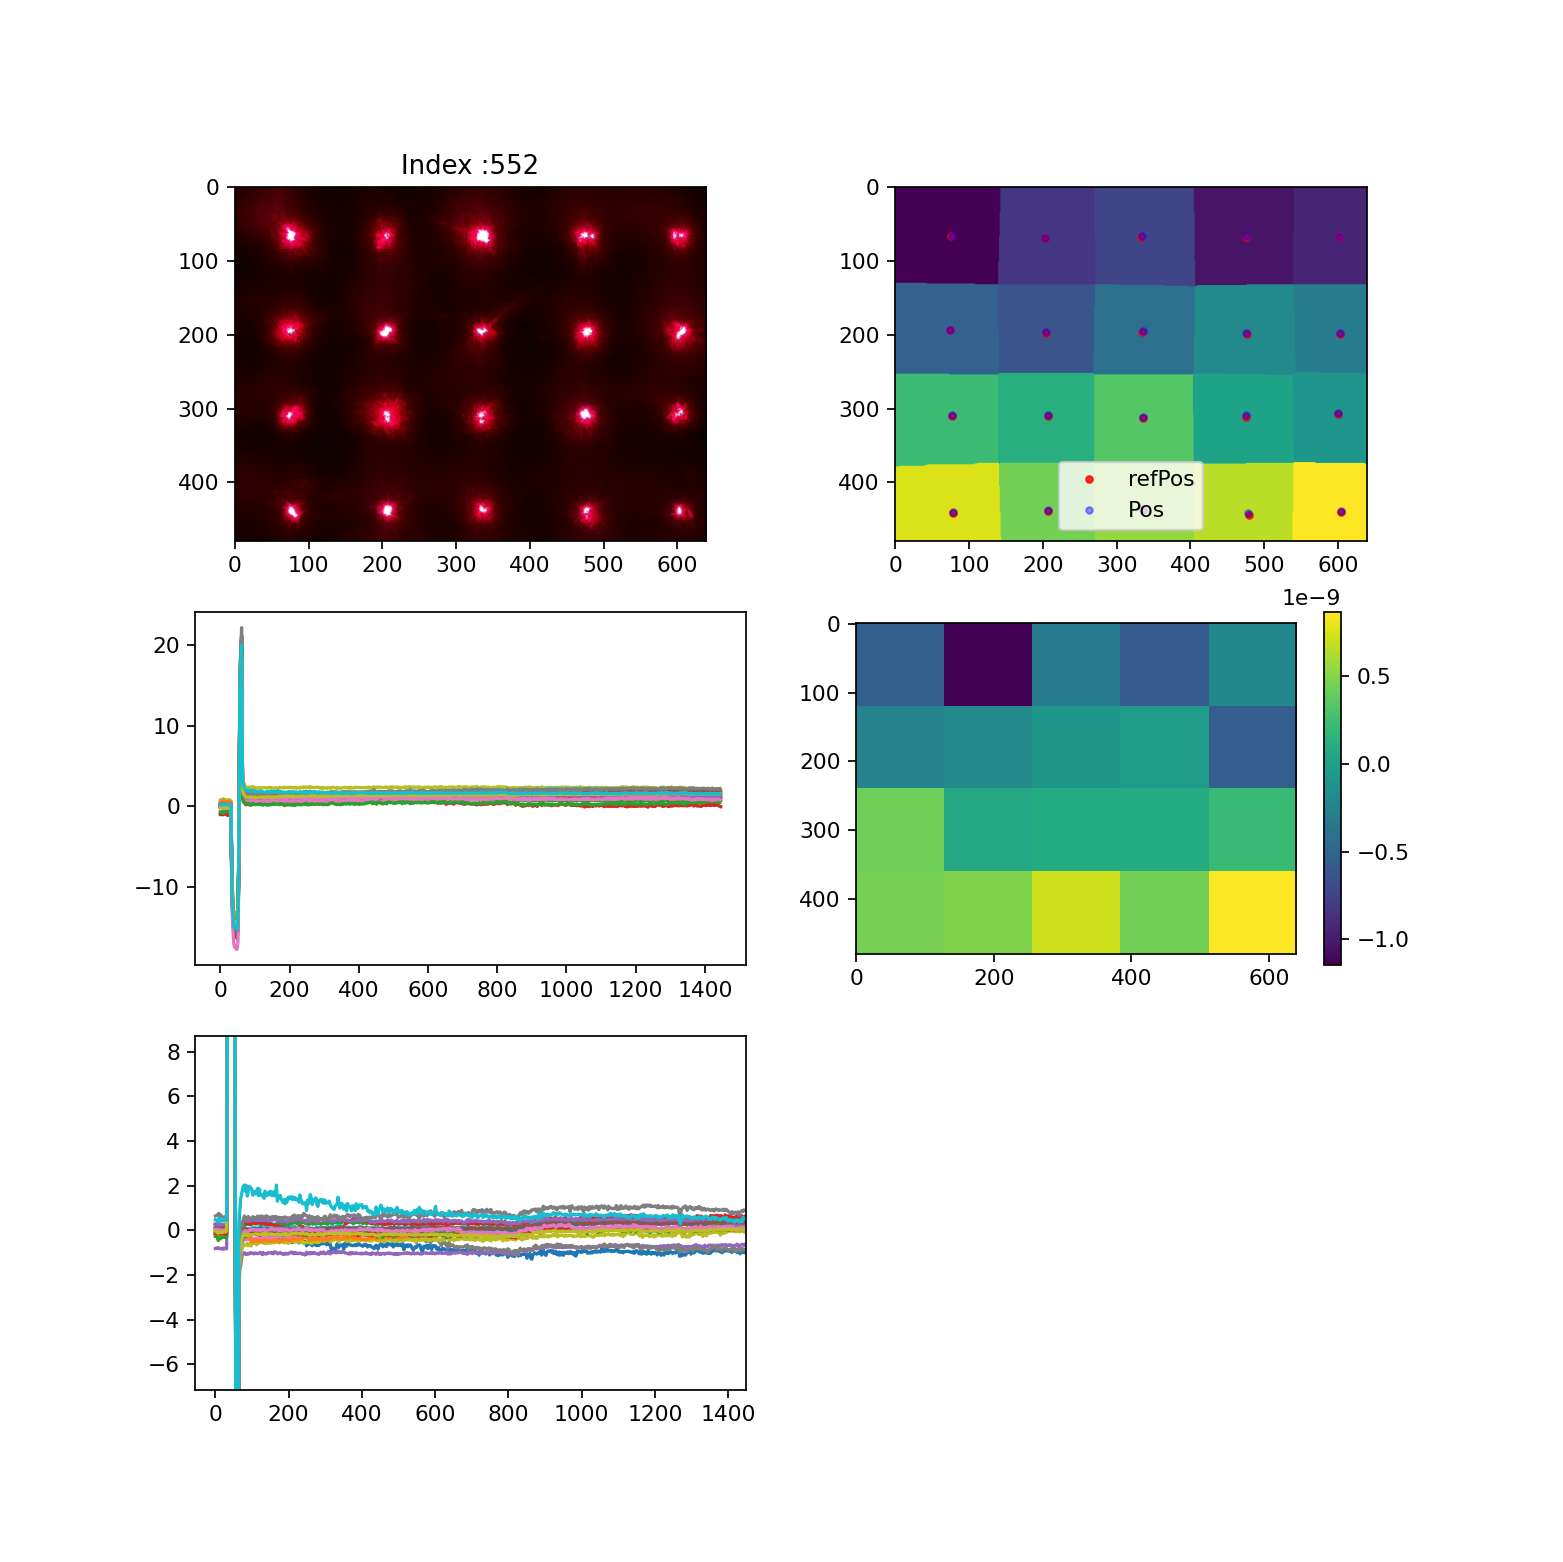

In [12]:
fig

<IPython.core.display.Javascript object>


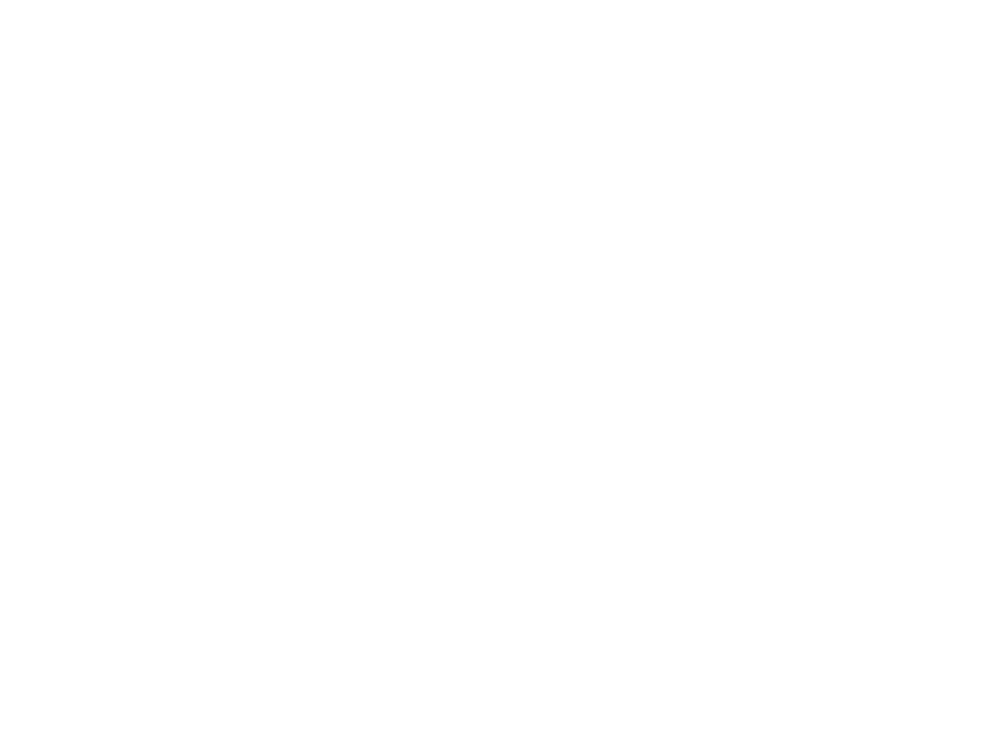

TypeError: savefig() takes 2 positional arguments but 3 were given

In [10]:
plt.savefig(fig,"asd.png",dpi=None)

## Fit to Zernike Polinom

In [9]:
ref_center

(array([ 57.44663833, 316.78363118, 457.66947784, 581.61159464,
        191.60110809,  56.1130801 , 313.56424045, 459.78895578,
        583.69408706, 187.66626087, 581.83577136,  58.01980084,
        186.20530183, 314.74802031, 459.33899575, 456.4915165 ,
        579.63121715,  57.94509538, 194.66044979, 315.8869784 ]),
 array([ 52.95025754,  55.20732335,  55.02300792,  57.99102711,
         59.40016717, 180.82515781, 180.08194036, 184.1332709 ,
        183.39544046, 180.49851619, 292.66123663, 294.05345212,
        296.42271731, 297.74009172, 295.76805071, 425.9847779 ,
        426.1107472 , 426.72072428, 423.86869986, 423.80863764]))

In [13]:
np.save("PhasePront.npy",Z)

<IPython.core.display.Javascript object>


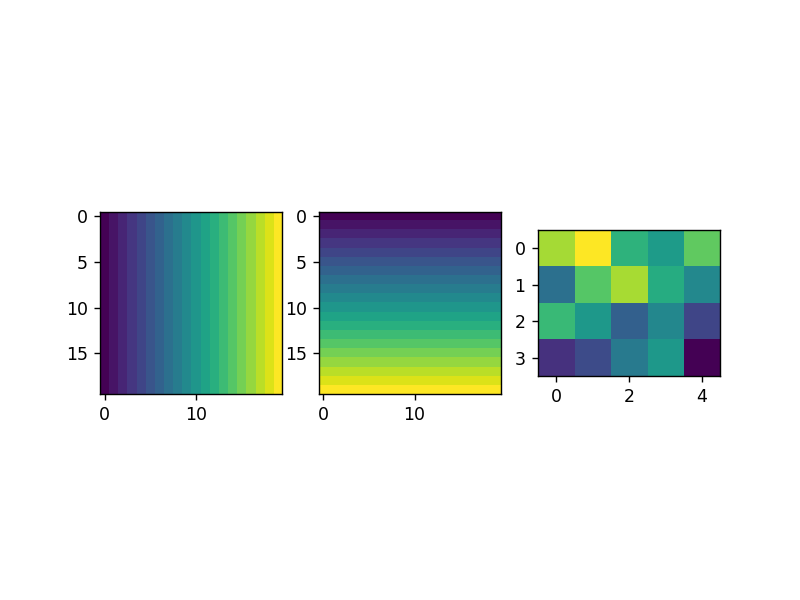

In [14]:
x = np.arange(0,20)
y = np.arange(0,20)

X,Y = np.meshgrid(x,y)

fig,axs = plt.subplots(1,3)

axs[0].imshow(X)
axs[1].imshow(Y)

#Z = 100 + ((-3.1*X) + (2.7*Y))
axs[2].imshow(Z)



In [50]:
modle.shape

(400, 3)

In [19]:
modle = np.stack([np.ones(400),X.ravel(),Y.ravel()],1)

plt.figure()
plt.plot(modle[:,0])
plt.plot(modle[:,1])
plt.plot(Z.ravel())
print(np.linalg.lstsq(modle,Z.ravel(),rcond=None))


ValueError: all input arrays must have the same shape

In [15]:
z1 = lambda x,y : x
z2 = lambda x,y : y
z3 = lambda x,y : -1*x**2 + y**2
z4 = lambda x,y : 2*x*y
z5 = lambda x,y : -1 + 2*x**2 + 2+y**2
z6 = lambda x,y : -3*x**2*y + y**3
z7 = lambda x,y : -1*x**3 + 2*x*y**2
#z8 = lambda x,y : -2y + 3*x**2 + 2+y**2

ZernikeFunctions = [z1,z2,z3,z4,z5,z6,z7]


In [16]:
M.shape

NameError: name 'M' is not defined

In [30]:
len(ZernikeFunctions)

7

In [39]:
Z = np.zeros((len(ZernikeFunctions),len(center[0]))

for i, p in enumerate(ZernikeFunctions):
    Z[i,:] = p(center[0],center[1])
    
    

SyntaxError: invalid syntax (3817695256.py, line 3)

<IPython.core.display.Javascript object>


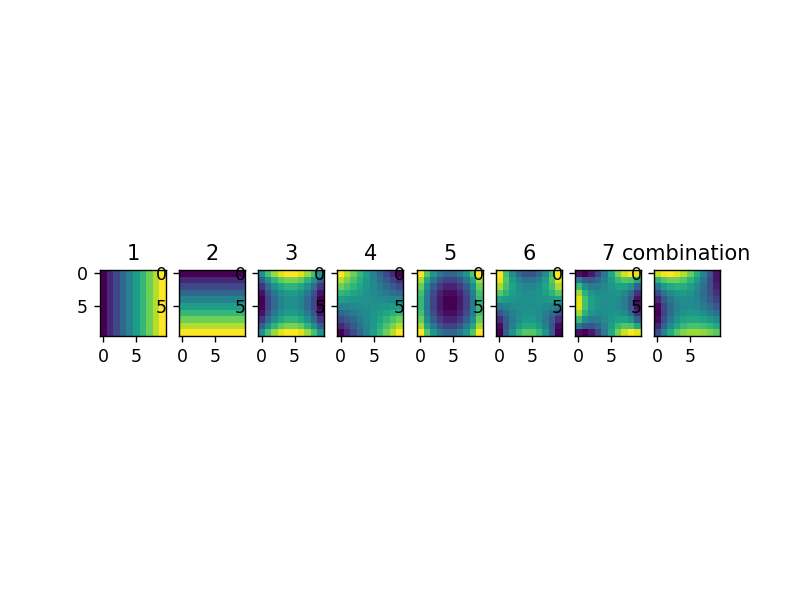

CPU times: user 754 µs, sys: 90 µs, total: 844 µs
Wall time: 887 µs


(array([ 8.68416957e-16, -6.66133815e-16,  4.00000000e+00,  2.00000000e+00,
         1.52313731e-15, -1.08588680e-15, -1.00000000e+00]),
 array([1.36769353e-28]),
 7,
 array([23.63300201,  8.58043141,  8.14814815,  6.44814152,  5.30885684,
         5.04390506,  4.91988364]))

In [18]:
x = np.linspace(-1,1,10)

X,Y = np.meshgrid(x,x)

fig,axs = plt.subplots(1,np.size(ZernikeFunctions) + 1) 

M = np.zeros((np.size(X.ravel()),np.size(ZernikeFunctions)))

xKlein =  2*ZernikeFunctions[3](X,Y) + 4*ZernikeFunctions[2](X,Y) + -1*ZernikeFunctions[6](X,Y)

for i, p in enumerate(ZernikeFunctions):
    
    Zernike_values = p(X,Y)
    axs[i].imshow(Zernike_values)
    axs[i].set_title(str(i+1))
    M[:,i] = Zernike_values.ravel()


axs[i+1].imshow(xKlein)
axs[i+1].set_title("combination")

%time np.linalg.lstsq(M ,xKlein.ravel(),rcond=None)

#axs[2].imshow(M)


In [6]:
print(Y.shape,X.shape,Z.shape)


NameError: name 'Z' is not defined

<IPython.core.display.Javascript object>


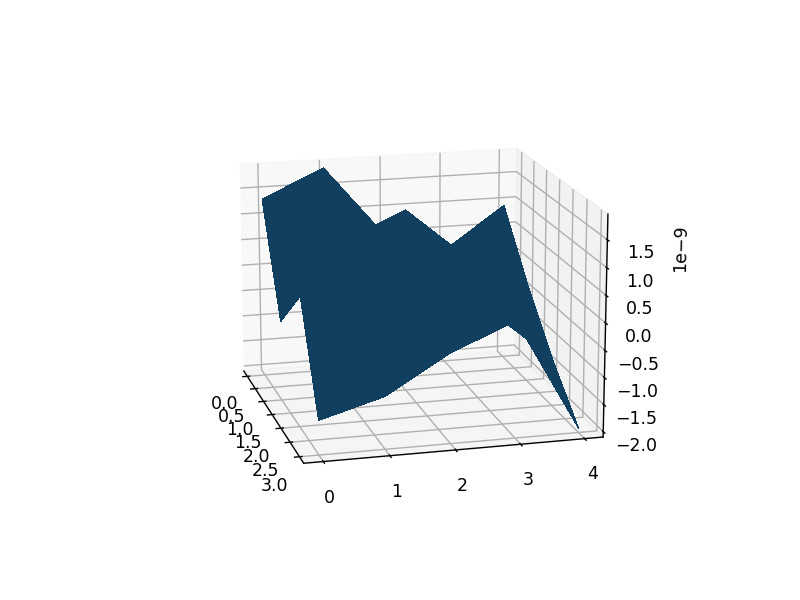

In [22]:
X = np.arange(0, Z.shape[1])
Y = np.arange(0, Z.shape[0])
X, Y = np.meshgrid(X, Y)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(Y,X, Z, linewidth=0, antialiased=False)


In [21]:
Z2 = np.linalg.lstsq(D,np.concatenate([partners[0],partners[1]]),rcond=None)[0]

LinAlgError: Incompatible dimensions

 ## Timing examples

In [ ]:

indx = 0 

resolution = (640,480)
#resolution = (1280,720)
#resolution = (1640,1232)
#resolution =(2016, 1520)

min_distance = 80

indx_end = 1000

with picamera.PiCamera(
    # Camera Setup 
    sensor_mode= 4,  
    resolution= resolution,
    framerate= 30
) as camera:
     # addition camera setup
    time.sleep(1)  # let the camera warm up and set gain/white balance
    camera.exposure_mode = 'off'
    camera.awb_mode = 'off'
    camera.awb_gains = 2.5

    camera.shutter_speed = int(6e6)
    camera.iso = 50
    output = np.zeros((*reversed(resolution),3), dtype=np.uint8)
    
    # get ref image
    for i in range(5):
        camera.capture(output,'rgb',use_video_port=True)
        
    PIL_ref_img = Image.fromarray(output,'RGB')
    ref_img = np.mean(PIL_ref_img,2) 
    
    # precess pef image
    ref_lables = sh.analyse.getSeperation(ref_img,min_distance=min_distance)
    ref_center = sh.analyse.getMomentum(ref_lables,ref_img, algorythm="C") 
    ShiftOverTimeX = np.zeros((len(ref_center[0]),indx_end))
    ShiftOverTimeY = np.zeros((len(ref_center[0]),indx_end))
    
    timeOfCapture = np.zeros(indx_end)
    timeOfCapture[0] = 0
    
    t0 = time.time_ns()
    
    for i in range(0,indx_end):
        t1 = time.time_ns()
        # continuous capture 
        camera.capture(output,'rgb',use_video_port=True) # 50ms
        timeOfCapture[i] = (time.time_ns() - t0) /1e9
        
        Sensor_img = Image.fromarray(output,'RGB') #5ms
        
        img = np.int16(output)
        img = np.uint8((img[:,:,0] + img[:,:,1] + img[:,:,2])/3)

        #%time img = np.mean(Sensor_img,2)
        
        center = sh.analyse.getMomentum(ref_lables, img, algorythm="C") 
        partners = sh.analyse.getPartner(center, ref_center)
        
        
        ShiftOverTimeX[:,i] = partners[0]
        ShiftOverTimeY[:,i] = partners[1]
        display(clear=True)
        print("idx: " + str(indx) + "  " + str((time.time_ns() - t1)/1e6))
        indx += 1 
        

In [ ]:
end

In [ ]:
(i+1)*win

In [ ]:
i*win

In [ ]:
plt.plot(ShiftOverTimeX.T[:,1])

win = 3

sig = ShiftOverTimeX.T[:,1]
end = len(sig)//3

m = np.zeros((end))

for i in range((end-1*win)):
    m[i] = np.mean(sig[i*win:(i+1)*win])
    



In [ ]:
plt.plot(ShiftOverTimeX.T[:,1])
plt.plot(m)
plt.xlim((0,300))